In [5]:
import gym
from autograd import grad, jacobian
import autograd.numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [6]:
class ILqr:
    
    def __init__(self, dynamics, running_cost, final_cost, state_dim, horizon=50):
        
        self.f = dynamics
        self.horizon = horizon
        
        self.f_x = jacobian(self.f,0)
        self.f_u = jacobian(self.f,1)
        
        self.f_xx = jacobian(self.f_x, 0)
        self.f_uu = jacobian(self.f_u, 1)
        self.f_ux = jacobian(self.f_u, 0)
        
        self.lf = final_cost
        self.lf_x = grad(self.lf,0)
        self.lf_xx = jacobian(self.lf_x,0)
        
        
        self.v = [0.0 for _ in range(horizon+1)]
        self.v_x = [np.zeros(state_dim) for _ in range(horizon+1)]
        self.v_xx = [np.zeros((state_dim,state_dim)) for _ in range(horizon+1)]
        
        self.l = running_cost
        self.l_x = grad(self.l,0)
        self.l_u = grad(self.l,1)
        
        self.l_xx = jacobian(self.l_x,0)
        self.l_uu = jacobian(self.l_u,1)
        self.l_ux = jacobian(self.l_u,0)
        
    def backward(self, x_seq, u_seq):
        
        self.v[-1] = self.lf(x_seq[-1],u_seq[-1])
        self.v_x[-1] = self.lf_x(x_seq[-1],u_seq[-1])
        self.v_xx[-1] = self.lf_xx(x_seq[-1],u_seq[-1])
        
        k_seq = []
        kk_seq = []
        
        for t in range(self.horizon-1,-1,-1):
            
            x = x_seq[t]
            u = u_seq[t]
            
            # Evaluate expansion coeeficients
            f_x_t = self.f_x(x,u)
            f_u_t = self.f_u(x,u)
            
            f_xx_t = self.f_xx(x,u)
            f_uu_t = self.f_uu(x,u)
            f_ux_t = self.f_ux(x,u)
            
            l_x_t = self.l_x(x,u)
            l_u_t = self.l_u(x,u)
            
            l_xx_t = self.l_xx(x,u)
            l_uu_t = self.l_uu(x,u)
            l_ux_t = self.l_ux(x,u)
            
            v_x_t = self.v_x[t+1]
            v_xx_t = self.v_xx[t+1]
            
            q_x = l_x_t + np.matmul(f_x_t.T,v_x_t)
            q_u = l_u_t + np.matmul(f_u_t.T,v_x_t)
            
            q_xx = l_xx_t + np.matmul(np.matmul(f_x_t.T,v_xx_t),f_x_t) + (v_x_t.reshape(-1,1,1)*f_xx_t).sum(axis=0)
            
            q_uu = l_uu_t + np.matmul(np.matmul(f_u_t.T,v_xx_t),f_u_t) + (v_x_t.reshape(-1,1,1)*f_uu_t).sum(axis=0)
            
            q_ux = l_ux_t + ((f_u_t.T).dot(v_xx_t)).dot(f_x_t) + (v_x_t.reshape(-1,1,1)*f_ux_t).sum(axis=0)
        
            # Invert with some regularisation
            q_uu_inv = np.linalg.inv(q_uu.reshape(1,1)+1e-9*np.eye(q_uu.shape[0]))
            
            k = -q_uu_inv.dot(q_u) # open loop gain
            kk = -q_uu_inv.dot(q_ux) # feedback gain
            
            
            self.v[t] += 0.5*(k.T.dot(q_uu)).dot(k) + k.T.dot(q_u)#q_u.dot(k)
            self.v_x[t] = q_x + (kk.T.dot(q_uu)).dot(k) + kk.T.dot(q_u) + q_ux.T.dot(k)#q_u.dot(kk)
            self.v_xx[t] = q_xx + (kk.T.dot(q_uu)).dot(kk) + kk.T.dot(q_ux) + q_ux.T.dot(kk)#q_ux.T.dot(kk)
            
            k_seq.append(k)
            kk_seq.append(kk)
        
        k_seq.reverse()
        kk_seq.reverse()
        
        return k_seq,kk_seq
    
    def forward(self, x_seq, u_seq, k_seq, kk_seq,alpha):
        
        x_seq_hat = np.array(x_seq)
        u_seq_hat = np.array(u_seq)
        
        for t in range(len(u_seq)):
            control = alpha**t*k_seq[t] + np.matmul(kk_seq[t], (x_seq_hat[t] - x_seq[t]))
            u_seq_hat[t] = np.clip(u_seq[t] + control,-2,2)
            x_seq_hat[t+1] = self.f(x_seq_hat[t], u_seq_hat[t])
            
        return x_seq_hat, u_seq_hat

    
def cost(x,u):
    costs = angle_normalize(x[0])**2 + .1*x[1]**2 + .001*(u**2)

    return costs


def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)


def pendulum_dyn(x,u):
    
        th = x[0]
        thdot = x[1]

        g = 10.
        m = 1.
        l = 1.
        dt = 0.05

        u = np.clip(u, -2, 2)[0]

        newthdot = thdot + (-3*g/(2*l) * np.sin(th + np.pi) + 3./(m*l**2)*u) * dt
        newth = th + newthdot*dt
        newthdot = np.clip(newthdot, -8, 8)

        x = np.array([newth, newthdot])
        return x

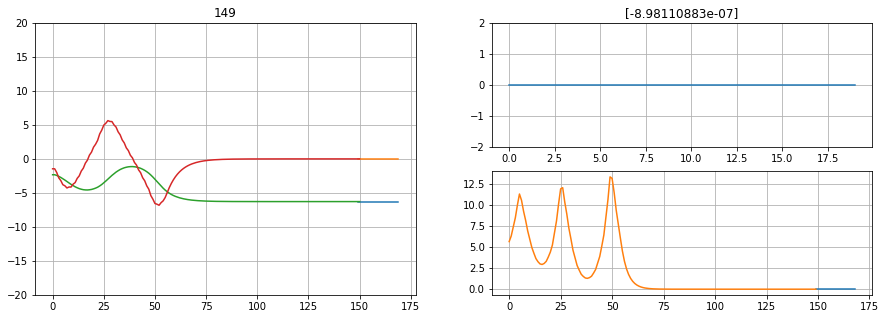

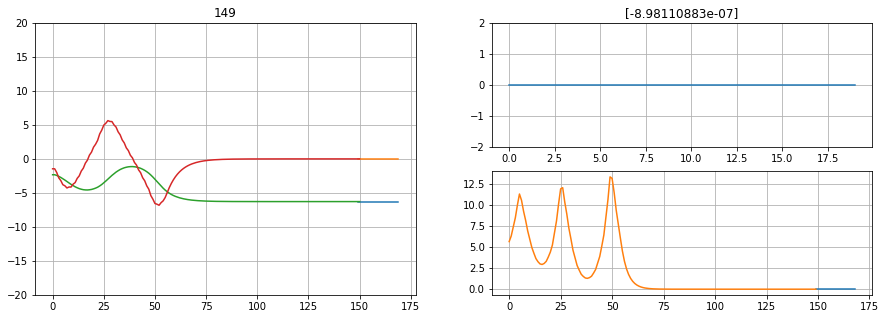

In [8]:
ilqr = ILqr(lambda x, u: pendulum_dyn(x, u), lambda x, u: cost(x,u), lambda x, u: cost(x,u), 2, horizon=20)

from IPython import display

env = gym.make("Pendulum-v1")
env.reset()

# Assume start high enough to stabilise
state,_,_,_ = env.step([0])
u_seq = [np.array((0.0,)) for _ in range(ilqr.horizon)]


st_seq = []
th = np.arctan2(state[1],state[0])
if (th >= 0):
    th = th - 2*np.pi
st_seq.append(np.array((th,state[2])))

c_seq = []
plt.figure(figsize=(15,5))
for j in range(150):
    
    x_seq = [np.array((th,state[2]))]
    c_seq.append(cost(x_seq[0],u_seq[0]))
    
    for t in range(ilqr.horizon):
        x_seq.append(pendulum_dyn(x_seq[-1], u_seq[t]))

    for rep in range(3):
        k_seq, kk_seq = ilqr.backward(x_seq, u_seq)
        x_seq, u_seq = ilqr.forward(x_seq, u_seq, k_seq, kk_seq,alpha=0.99)
    
    st_seq.append(np.array((th,state[2])))
    
    env.render()
    state,_,_,_ = env.step(u_seq[0])
    
    th = np.arctan2(state[1],state[0])
    if (th >= 0):
        th = th - 2*np.pi
    
    
    plt.cla()
    plt.subplot(1,2,1)
    plt.cla()
    plt.plot(np.arange(j,j+ilqr.horizon+1),x_seq)
    plt.plot(np.array(st_seq)[:,0])
    plt.plot(np.array(st_seq)[:,1])
    plt.ylim(-20,20)
    plt.grid()
    plt.title(j)

    plt.subplot(2,2,2)
    plt.cla()
    plt.plot(u_seq)
    plt.title(u_seq[0])
    plt.ylim(-2,2)
    plt.grid()
    
    plt.subplot(2,2,4)
    plt.cla()
    plt.plot(np.arange(j,j+ilqr.horizon),[cost(x_seq[t],u_seq[t]) for t in range(len(u_seq))])
    plt.plot(c_seq)
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())
        
env.close()